In [2]:
import os
import sys
import cv2
import csv
import PIL
import h5py
import math
import glob
import openslide
import numpy as np
import skimage.filters as sk_filters
import matplotlib.pyplot as plt

from skimage import io, morphology, color
from PIL import Image, ImageDraw, ImageFont
from openslide.deepzoom import DeepZoomGenerator
from openslide import OpenSlideError, OpenSlideUnsupportedFormatError

In [3]:
BASE_DIR = os.path.join("../", "datasets/Camelyon17/")
MASK_DIR = os.path.join(BASE_DIR, "masks/")
LEVEL = 8 # 0=highest resolution

## Visualize WSI

In [4]:
def open_slide(filename):
    """
    Create Openslide Object from a WSI (.svs, .tif, .ndpi, etc).
    
    Args:
        filename (str): Name of the slide file to open.
    
    Returns:
        An OpenSlide object representing a whole-slide image.
    """
    try:
        slide = openslide.open_slide(filename)
    except OpenSlideUnsupportedFormatError:
        slide = None
        print("Unrecognized file format.")
    except OpenSlideError:
        slide = None
        print("Slide file recognized. OpenSlide error.")
    except FileNotFoundError:
        slide = None
        print("Slide file not found.")
    return slide


def get_slide_info(filename):
    """
    Display information about the magnification levels in the WSI:
        - Level count: Number of different image resolutions available within the WSI.
        - Level dimensions: Pixel dimensions of the entire grid at a particular resolution level.
    
    Args:
        filename (str): Name of the slide file.
    """
    
    slide = openslide.open_slide(filename)
    level_count = slide.level_count
    level_dimensions = slide.level_dimensions
    level_downsamples = slide.level_downsamples
#     print("Level count:         " + str(level_count))
#     print("Level dimensions:    " + str(level_dimensions))
    return level_count, level_dimensions, level_downsamples


def read_slide(slide, location, level, size, as_float=False):
    """
    Read a region of the WSI with Top Left corner at (x, y) at a certain resolution level
    
    Args:
        - slide     :    Openslide Object
        - location  :    (x, y) tuple giving the top left pixel in the level 0 reference frame
        - level     :    resolution level
        - size      :    (width, height) tuple giving the region size
    """
    img = slide.read_region(location, level, size)
    img = img.convert('RGB') # drop the alpha channel
    if as_float:
        img = np.asarray(img, dtype=np.float32)
    else:
        img = np.asarray(img)
    assert img.shape == (size[1], size[0], 3)
    return img


def display_slide(filename, level):
    """
    Display a scaled down version of a WSI.
    
    Args:
        - filename (str): name of the WSI to display.
        - level: resolution level
    """
    image_slide = open_slide(sample_slide)
    image = read_slide(image_slide, 
                       (0,0), 
                       level, 
                       (image_slide.level_dimensions[level][0], 
                        image_slide.level_dimensions[level][1]))

    plt.figure(figsize=(10, 10), dpi=100)
    plt.title("showing slide for: {}".format(os.path.splitext(os.path.basename(filename))[0]))
    plt.imshow(image)

Total number of WSIs:  10
sample_slide:  ../datasets/Camelyon17/training/center_4/patient_080_node_3.tif
Level count:  9
Level dimensions:  ((113664, 92160), (56832, 46080), (28416, 23040), (14208, 11520), (7104, 5760), (3552, 2880), (1776, 1440), (888, 720), (444, 360))
Level downsamples:  (1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0)


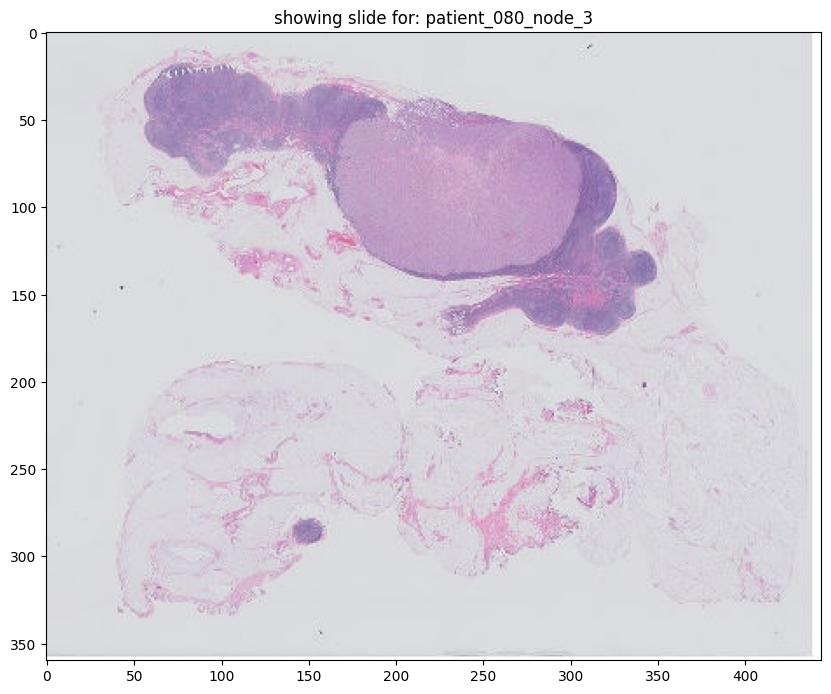

In [5]:
slides = glob.glob(BASE_DIR + 'training/center_*/patient_*.tif')
sample_slide = slides[8]
print("Total number of WSIs: ", len(slides))
print("sample_slide: ", sample_slide)
level_count, level_dimensions, level_downsamples = get_slide_info(sample_slide)
print("Level count: ", level_count)
print("Level dimensions: ", level_dimensions)
print("Level downsamples: ", level_downsamples)

display_slide(sample_slide, LEVEL)

## Tissue - Background Segmentation in WSI

In [5]:
def filter_otsu_threshold(np_img, output_type="uint8"):
    """
    Compute Otsu threshold on image as a NumPy array and return binary image based on 
    pixels above threshold.
    
    Args:
        np_img: Image as a NumPy array.
        output_type: Type of array to return (bool, float, or uint8).
    
    Returns:
        NumPy array (bool, float, or uint8) where True, 1.0, and 255 represent a pixel 
        above Otsu threshold.
    """
    otsu_thresh_value = sk_filters.threshold_otsu(np_img)
    otsu = (np_img > otsu_thresh_value)
    if output_type == "bool":
        pass
    elif output_type == "float":
        otsu = otsu.astype(float)
    else:
        otsu = otsu.astype("uint8") * 255
    return otsu


def segment_tissue_from_background(slide, level):
    """
    Segment the Tissue foreground from the background through a series of transformation:
    RGB --> Remove black background pixels--> HSV --> Median Blurring -->
    Thresholding --> Morphological Operations to fill holes
    
    NOTE: In some of the CAMELYON17 cases, the Otsu’s thresholding failed because of the
    black regions in the WSI. So before the application of image thresholding operation,
    the black pixel regions in the WSI background are replaced with white pixels.
    
    Args:
        slide: Path to the slide to segment.

    Returns:
        cleaned: a ndarray (n=2) containing a binary Tissue mask.
    """
    image_slide = open_slide(slide)
    img = read_slide(image_slide, 
                       (0,0), 
                       level, 
                       (image_slide.level_dimensions[level][0], 
                        image_slide.level_dimensions[level][1])).copy()
    #remove black background in some WSI
    img[np.where((img==[0,0,0]).all(axis=2))] = [255,255,255]
    
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    img_med = cv2.medianBlur(img_hsv[:, :, 1], 7)

    otsu = filter_otsu_threshold(img_med)
    arr = otsu>0
#     cleaned = morphology.dilation(arr)
    cleaned = morphology.remove_small_objects(arr, min_size=4)
    cleaned = morphology.remove_small_holes(cleaned, area_threshold=16)
    cleaned = morphology.opening(cleaned, morphology.disk(4))
    return cleaned


def overlay_img_and_segmentation_mask(img, mask):
    """
    Display the segmentation mask on top of the image.
    
    Args:
        - img: Image to be segmented.
        - mask: Segmented mask of the Image.
    """
    # Construct RGB version of gray-level mask
    mask_color = np.dstack((mask, mask, mask))

    # Convert the input image and color mask to the HSV colorspace
    img_hsv = color.rgb2hsv(img)
    mask_hsv = color.rgb2hsv(mask_color)

    # Replace the hue and saturation of the original image with that of the color mask
    mask_hsv[..., 0] = img_hsv[..., 0]
    mask_hsv[..., 1] = img_hsv[..., 1] * alpha

    img_segmented = color.hsv2rgb(mask_hsv)

    return img_segmented

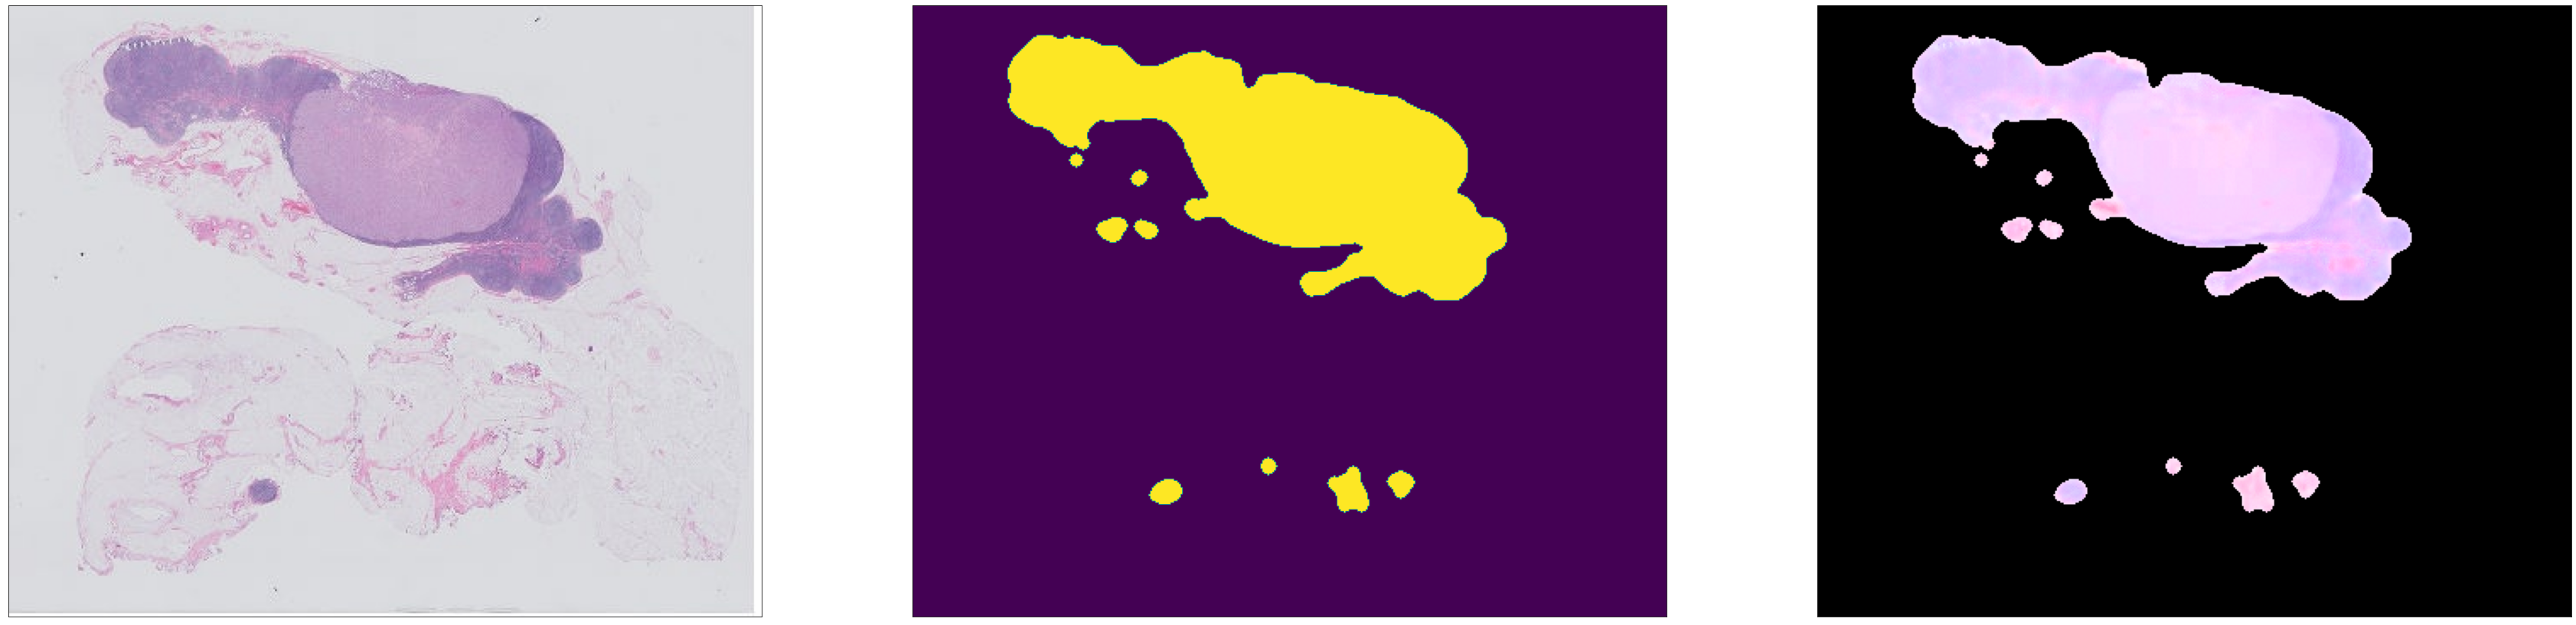

In [6]:
alpha = 0.9
image_slide = open_slide(sample_slide)
img = read_slide(image_slide, (0,0), LEVEL, (image_slide.level_dimensions[LEVEL][0], image_slide.level_dimensions[LEVEL][1]))
mask = segment_tissue_from_background(sample_slide, LEVEL)

img_segmented = overlay_img_and_segmentation_mask(img, mask)

# Display the output
f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(60, 60), subplot_kw={'xticks':[], 'yticks':[]})
ax0.imshow(img, cmap=plt.cm.gray)
ax1.imshow(mask)
ax2.imshow(img_segmented)
plt.show()

In [7]:
def display_segmentation_pipeline(slide, level):
    """
    Display the intermediate stages of the preprocessing pi peline.
    
    Args:
        - slide: WSI to be segmented.
        - level: Resolution level of the WSI.
    """
    image_slide = open_slide(slide)
    img = read_slide(image_slide, 
                       (0,0), 
                       level, 
                       (image_slide.level_dimensions[level][0], 
                        image_slide.level_dimensions[level][1])).copy()
    img_clean = img.copy()
    img_clean[np.where((img==[0,0,0]).all(axis=2))] = [255,255,255] #remove back background
    
    img_hsv = cv2.cvtColor(img_clean, cv2.COLOR_RGB2HSV)
    img_med = cv2.medianBlur(img_hsv[:, :, 1], 7)

    otsu = filter_otsu_threshold(img_med)
    
    arr = otsu>0
    mask = morphology.remove_small_objects(arr, min_size=4)
    mask = morphology.remove_small_holes(mask, area_threshold=16)
    mask = morphology.opening(mask, morphology.disk(4))
    
    #overlay img and mask
    mask_color = np.dstack((mask, mask, mask))
    img_hsv = color.rgb2hsv(img_clean)
    mask_hsv = color.rgb2hsv(mask_color)
    # Replace the hue and saturation of the original image with that of the color mask
    mask_hsv[..., 0] = img_hsv[..., 0]
    mask_hsv[..., 1] = img_hsv[..., 1] * alpha
    img_masked = color.hsv2rgb(mask_hsv)
    
    #plot    
    fig, axs = plt.subplots(2, 3, figsize=(50, 50),)
    axs[0, 0].imshow(img)
    axs[0, 0].set_title('Input WSI')   
    axs[0, 1].imshow(img_clean)
    axs[0, 1].set_title('Removing Black Background') 
    axs[0, 2].imshow(img_hsv[:, :, 1])
    axs[0, 2].set_title('Saturation Component of HSV')
    axs[1, 0].imshow(img_med)
    axs[1, 0].set_title('Median Filtering')
    axs[1, 1].imshow(otsu)
    axs[1, 1].set_title('Otsu Thresholding') 
    axs[1, 2].imshow(mask)
    axs[1, 2].set_title('Post Morphological Operation')
    plt.show()

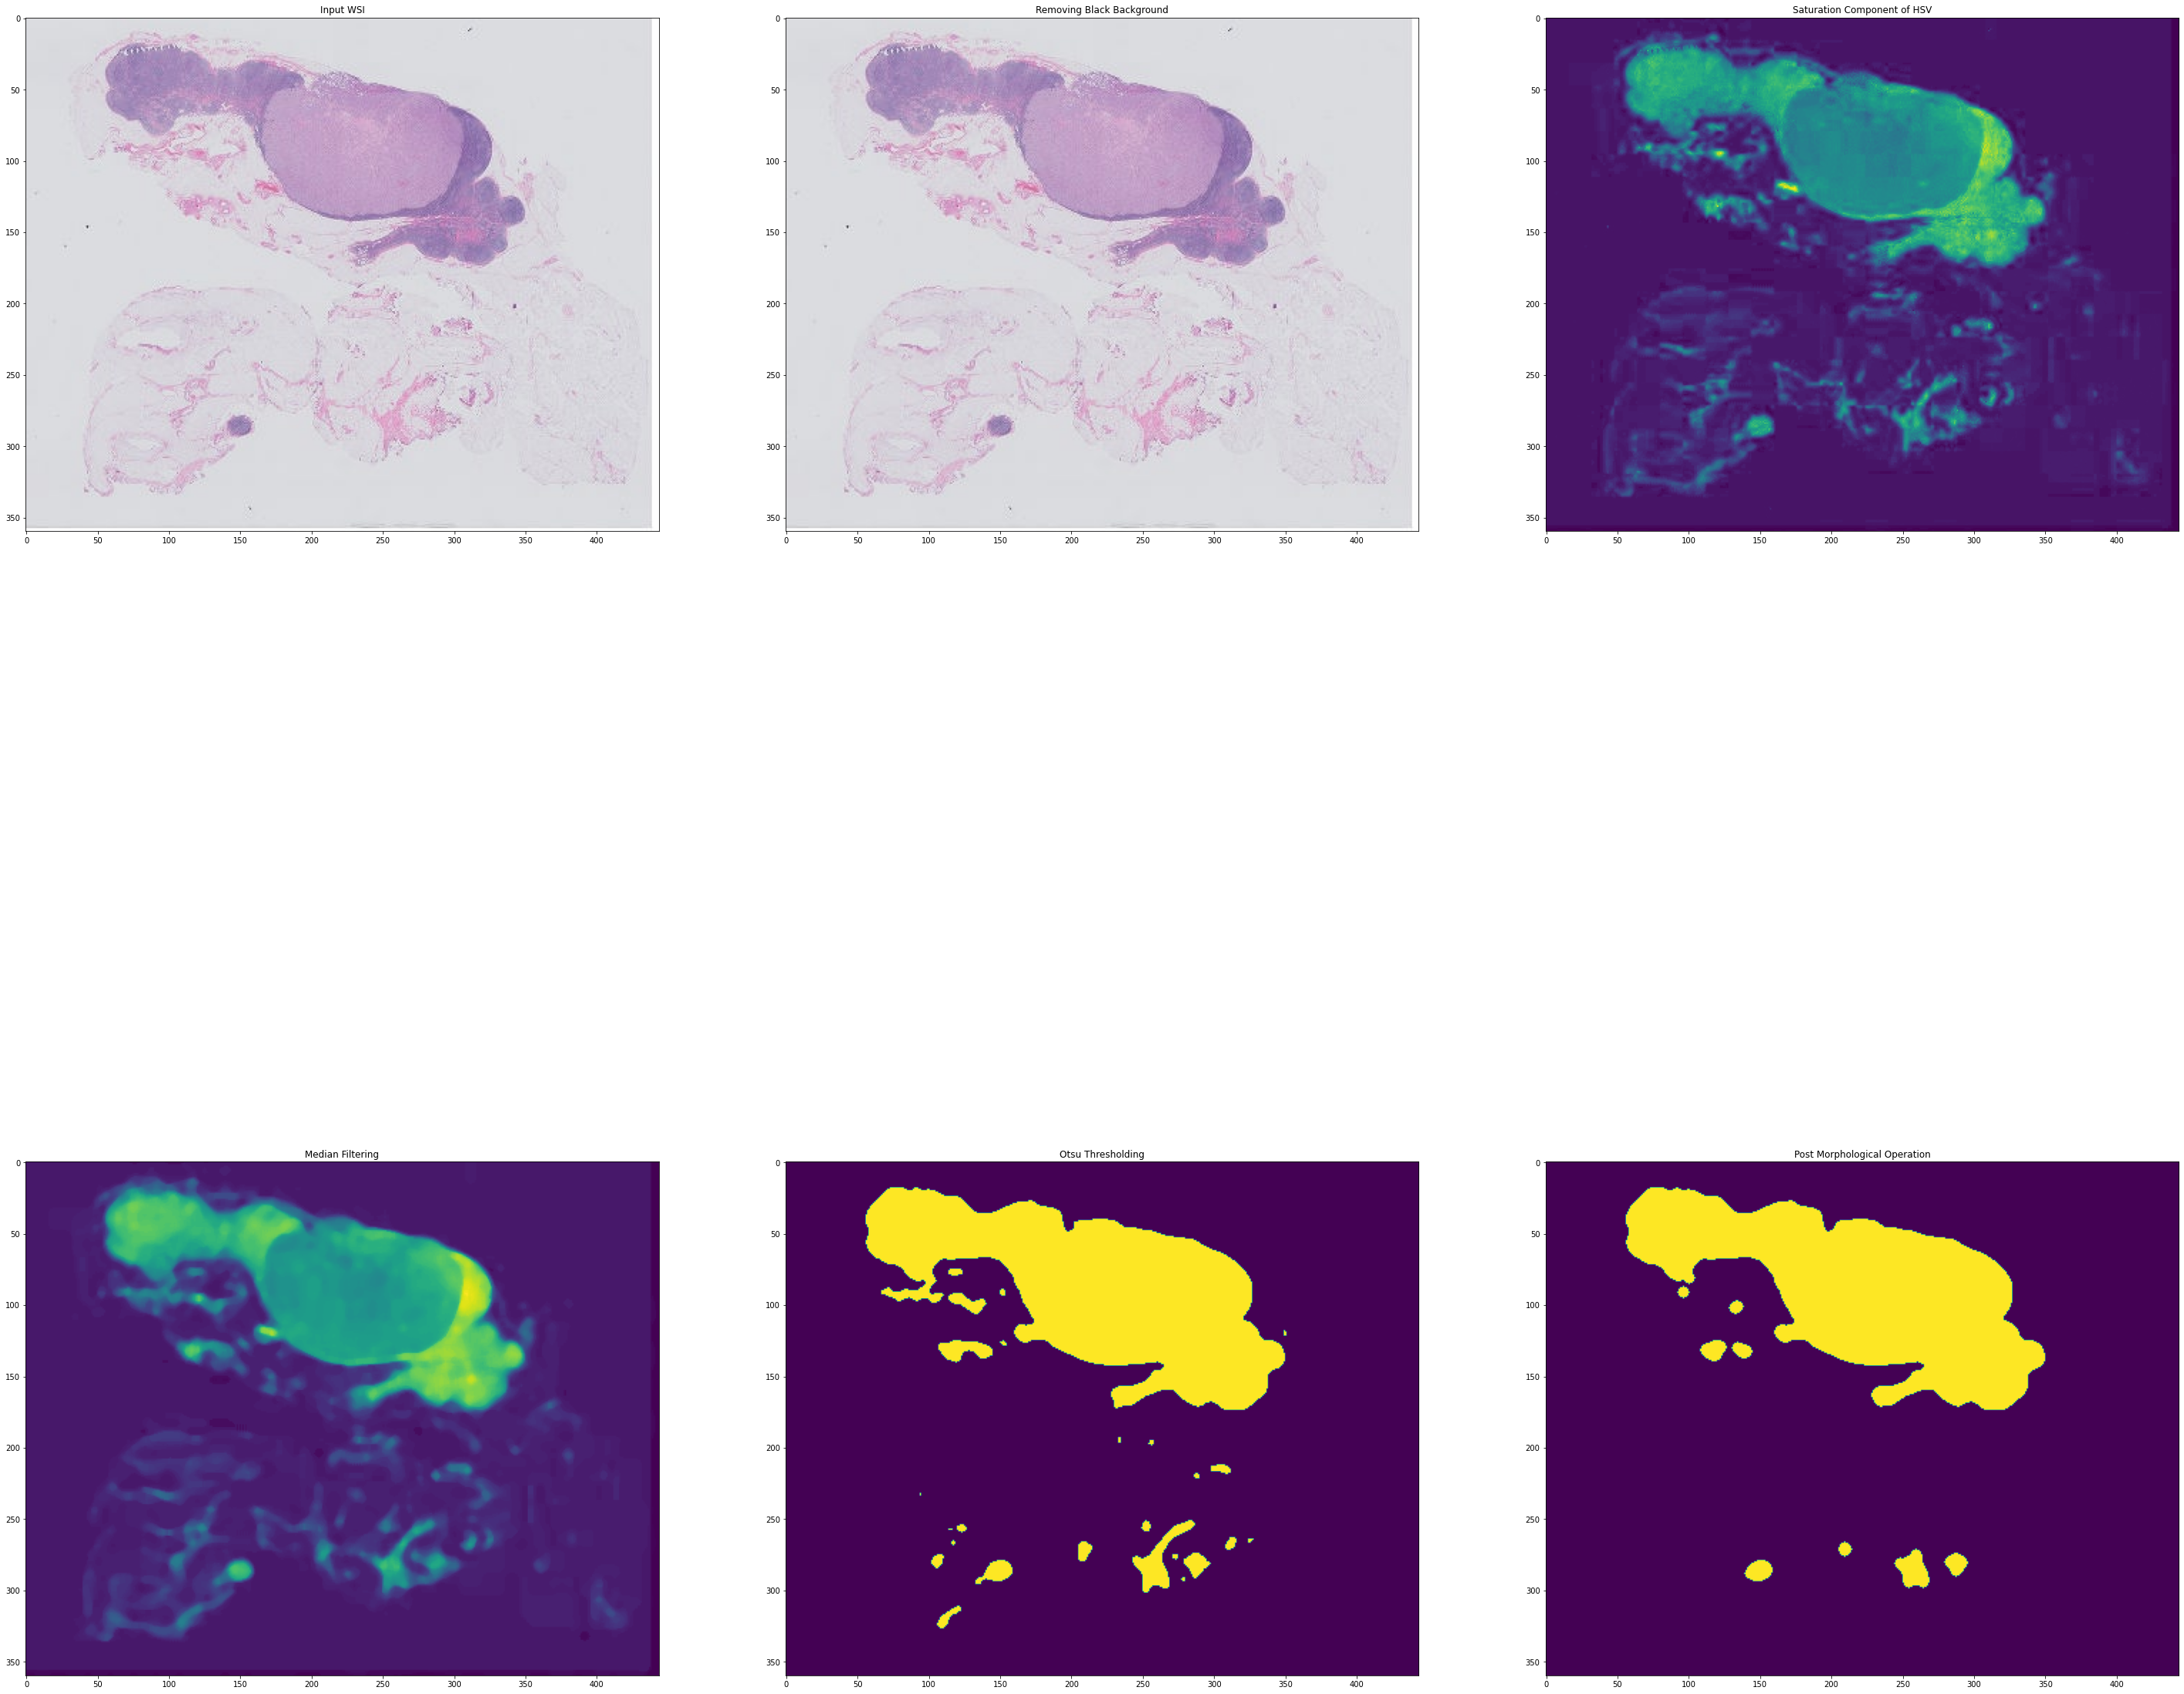

In [8]:
display_segmentation_pipeline(sample_slide, LEVEL)

## WSI Tiling

In [36]:
PATCH_DIR_H5 = os.path.join(BASE_DIR, "patches/h5/")
PATCH_DIR_PNG = os.path.join(BASE_DIR, "patches/png/")
STITCH_DIR = os.path.join(BASE_DIR, "stitches/")
PATCH_LEVEL = 12
PATCH_SIZE = 256
PIXEL_OVERLAP = 64 #overlap in patch extraction
STORAGE_OPTION = 'hdf5' #choose either one of 'hdf5' or 'disk'

In [108]:
def read_labels(label_filepath):
    """ 
    Reads the slide-level labels from the Camelyon17's stage_labels.csv file and clean it.
    
    Args:
        
    Returns:
        labelDict : dictionary of {slide_name: tumor_label} for all the slides in training folder
    """
    
    myDict = {y[0]: y[1] for y in [x.split(",") for x in open(label_filepath).read().split('\n') if x]}
    labelDict = {}

    for key, val in myDict.items():
        if '.tif' in key:
            labelDict[key] = val

    newDict = labelDict
    for key in list(labelDict):
        newDict[key.split('.')[0]] = newDict.pop(key) #remove '.tif' from keys
    
    for key, value in newDict.items():
        if value == 'negative':
            newDict[key] = 0
        if value == 'itc':
            newDict[key] = 1
        if value == 'micro':
            newDict[key] = 2
        if value == 'macro':
            newDict[key] = 3
            
    return newDict


def save_to_hdf5(file_name, patches, coords, labels, db_location=PATCH_DIR_H5):
    """ 
    Saves the numpy arrays to HDF5 files. All patches from a single WSI will be saved 
    to the same HDF5 file, regardless of the transaction size specified by rows_per_txn, 
    because this is the most efficient way to use HDF5 datasets.
    
    Args:
        - slide        :    file path to the WSI to be saved into hdf5
        - db_location  :    folder to save h5 data in
        - patches      :    list of numpy images
        - coords       :    x, y tile coordinates
        - file_name    :    original source WSI name
        - labels       :    dictionary of {slide_name: tumor_label} for all the slides in training folder
    """
    print("Saving patches in HDF5 file for {}.".format(file_name))
    
    if not os.path.exists(db_location):
        os.makedirs(db_location)
        
    # Save patches into hdf5 file.
    slide = file_name
    with h5py.File(db_location + 'training_newPatch.h5','a') as hf:
        patient_index = "_".join(os.path.basename(slide).split('.')[0].split('_')[:2])
        slide_index = "_".join(os.path.basename(slide).split('.')[0].split('_')[3])
        slide_label = labels[os.path.basename(slide)]
        grp = hf.require_group(patient_index)
        subgrp = grp.require_group('wsi_{}'.format(slide_index))
        
        for i, patch in enumerate(patches):
            subsubgrp = subgrp.create_group('patch_{}'.format(i))
            print("[save_to_hdf5] np.shape(patch): ", type(patch))
#             subsubgrp.create_dataset('image', np.shape(patch), data=patch,  compression="gzip", compression_opts=7)
            subsubgrp.create_dataset('image', shape=len(patch), data=patch) #np.array(patch).shape or len(patch)
            subsubgrp.create_dataset('label', np.shape(slide_label), data=slide_label)
#             subsubgrp.require_dataset('image', np.shape(patch), data=patch, dtype='uint8',  compression="gzip", compression_opts=7)
#             subsubgrp.require_dataset('label', np.shape(slide_label), data=slide_label, dtype='int64')
            subsubgrp.attrs["patch_coords"] = (coords[i][0], coords[i][1])


def save_to_disk(patches, coords, file_name, labels, db_location=PATCH_DIR_PNG):
    """ 
    Saves numpy patches to .png files (full resolution). 
    Meta data is saved in the file name.
    
    Args:
        - db_location  :    folder to save images in
        - patches      :    numpy images
        - coords       :    x, y tile coordinates
        - file_name    :    original source WSI name
        - labels       :    patch labels (opt)
    """
    print("Saving patches to disk (png).")
    
    if not os.path.exists(db_location):
        os.makedirs(db_location)
        
    save_labels = len(labels)
    for i, patch in enumerate(patches):
        patch_fname = file_name + "_" + str(coords[i][0]) + "_" + str(coords[i][1]) + "_"

        if save_labels:
            patch_fname += str(labels[i])
            
        Image.fromarray(patch).save(db_location + patch_fname + ".png")

In [38]:
 def patch_to_tile_size(patch_size, overlap):
    return patch_size - overlap*2


def sample_and_store_patches(slide_path,
                             label_filepath,
                             level,
                             pixel_overlap=64,
                             patch_size=256,
                             limit_bounds=False,
                             rows_per_txn=200,
                             storage_option='hdf5'):
    """ 
    Sample patches of specified size from WSI file.
    
    Args:
        - slides          :    list of all available WSI file paths
        - file_name       :    name of whole slide image to sample from
        - file_dir        :    directory file is located in
        - pixel_overlap   :    pixels overlap on each side
        - level           :    0 is lowest resolution; level_count - 1 is highest
        - rows_per_txn    :    how many patches to load into memory at once
        - storage_option  :    the patch storage option              
        
    Note: patch_size is the dimension of the sampled patches, NOT equivalent to 
    openslide's definition of tile_size.
    
    Return:
        Count(int): #patches extracted from the WSI
    """
    tile_size = patch_to_tile_size(patch_size, pixel_overlap)
    labels = read_labels(label_filepath)
    
    for file in slide_path:
        slide = open_slide(file)  
        tiles = DeepZoomGenerator(slide,
                                  tile_size=tile_size,
                                  overlap=pixel_overlap,
                                  limit_bounds=limit_bounds)

        if level >= tiles.level_count:
            print("[py-wsi error]: requested level does not exist. Number of slide levels: " 
                  + str(tiles.level_count))
            return 0

        x_tiles, y_tiles = tiles.level_tiles[level]
        print("x_tiles, y_tiles: ", x_tiles, y_tiles)
        print("level count: ", slide.level_count)

        x, y = 0, 0
        count, batch_count = 0, 0
        patches, coords = [], []
        while y < y_tiles:
            while x < x_tiles:
                new_tile = np.array(tiles.get_tile(level, (x, y)), dtype=np.uint8)
                # OpenSlide calculates overlap in such a way that sometimes depending on the 
                # dimensions, edge patches are smaller than the others. We will ignore such patches.
                if np.shape(new_tile) == (patch_size, patch_size, 3):
                    patches.append(new_tile)
                    coords.append(np.array([x, y]))
                    count += 1

                x += 1

            # To save memory, we will save data into the dbs every #rows_per_txn rows. i.e., 
            # each transaction will commit #rows_per_txn rows of patches. Write after last row 
            # regardless. HDF5 does NOT follow this convention due to efficiency.
            if (y % rows_per_txn == 0 and y != 0) or y == y_tiles-1:
                if storage_option == 'disk':
                    file_name = os.path.basename(slide_path).rsplit('.')[0]
                    save_to_disk(patches, coords, file_name, labels)
                if storage_option != 'hdf5':
                    del patches
                    del coords
                    patches, coords = [], [] # Reset right away.

            y += 1
            x = 0

        if storage_option == 'hdf5':
            file_name = os.path.basename(file).split('.')[0]
            save_to_hdf5(file_name, patches, coords, labels)
    print ("Total patches extracted: ", count)
    return count

In [12]:
label_filepath = os.path.join(BASE_DIR , 'training/stage_labels.csv')

slide_path = glob.glob("../datasets/Camelyon17/training/center_*/patient_*.tif")
print("Number of slides to process: ", len(slide_path))

sample_and_store_patches(slide_path,
                         label_filepath,
                         level=PATCH_LEVEL,
                         pixel_overlap=PIXEL_OVERLAP,
                         patch_size=PATCH_SIZE,
                         limit_bounds=True,
                         rows_per_txn=200,
                         storage_option=STORAGE_OPTION)

Number of slides to process:  10
x_tiles, y_tiles:  12 26
level count:  9
Saving patches in HDF5 file for patient_000_node_3.
x_tiles, y_tiles:  12 26
level count:  9
Saving patches in HDF5 file for patient_000_node_4.
x_tiles, y_tiles:  12 26
level count:  9
Saving patches in HDF5 file for patient_000_node_2.
x_tiles, y_tiles:  12 25
level count:  9
Saving patches in HDF5 file for patient_000_node_0.
x_tiles, y_tiles:  12 25
level count:  9
Saving patches in HDF5 file for patient_000_node_1.
x_tiles, y_tiles:  25 12
level count:  10
Saving patches in HDF5 file for patient_080_node_0.
x_tiles, y_tiles:  19 10
level count:  10
Saving patches in HDF5 file for patient_080_node_2.
x_tiles, y_tiles:  18 12
level count:  10
Saving patches in HDF5 file for patient_080_node_4.
x_tiles, y_tiles:  28 23
level count:  9
Saving patches in HDF5 file for patient_080_node_3.
x_tiles, y_tiles:  21 11
level count:  10
Saving patches in HDF5 file for patient_080_node_1.
Total patches extracted:  162


162

## Verify HDF5 structure

In [9]:
# !pip install h5glance
from h5glance import H5Glance

In [19]:
read_h5 = h5py.File('../datasets/Camelyon17/patches/h5/training.h5', 'r+')
H5Glance(read_h5)

In [15]:
read_h5.close()

## Patch extraction testing

### Method #1

In [51]:
def isInHole(holes, point, patch_size):
    """
    Returns:
        1 if point inside hole contours, 0 otherwise
    
    """
    for hole in holes:
        if cv2.pointPolygonTest(hole, (point[0]+patch_size/2, point[1]+patch_size/2), False) > 0:
            return 1
    return 0


def isInContours(cont_check_fn, point, holes=None, patch_size=256):
    """
    Returns:
        1 if the point(s) are inside Tissue - Hole contours, 0 otherwise.
    """
    if cont_check_fn(point):
        if holes is not None:
            return not isInHole(holes, point, patch_size)
        else:
            return 1
    return 0


def isInContourSingle(contour, point, patch_size):
    """
    Test weather patch center is inside tissue contour.
    
    Args:
        - contour     : countour of tissue in WSI 
        - point       : top (x, y) coordinate of patch
        - patch_size  : size of the patch
    Return:
        1 if point is on/inside contour, 0 if its outside the contour
    """
    center = (point[0]+patch_size//2, point[1]+patch_size//2)
    return 1 if cv2.pointPolygonTest(contour, center, False) >= 0 else 0


def isInContourMulti(contour, point, patch_size, center_shift=0.5):
    """
    Test weather four points at some distance from the patch center are inside tissue contour.
    
    Args:
        contour     : countour of tissue in WSI 
        point       : top (x, y) coordinate of patch
        patch_size  : size of the patch
        center_shift : measure of what percentage of the distance between center and corner of patch do the four test-points lie
        
    Return:
        1 if point is on or inside contour, 0 if its outside the contour
    """
    shift = int(center_shift*patch_size//2)
    center = (point[0]+patch_size//2, point[1]+patch_size//2)
    
    if shift > 0:
        test_points = [(center[0]+shift, center[1]+shift),
                       (center[0]+shift, center[1]-shift),
                       (center[0]-shift, center[1]+shift),
                       (center[0]+shift, center[1]-shift)]
    else:
        test_points = [center]
    
    for points in test_points:
        if cv2.pointPolygonTest(contour, points, False) < 0:
            return 0
        
    return 1


def filter_contours(contours, hierarchy, area_threshold_tissue, area_threshold_hole, max_n_holes):
    """
    Filter contours by area.
    
    Args:
        - contours              :  all countours in WSI 
        - hierarchy             :  
        - area_threshold_tissue :  tissues with areas higher than this threshold are significant
        - area_threshold_hole   :  holes with area higher than this threshold are significant and considered (deducted from patching)
        - max_n_holes           :  maximum number of holes to consider
        
    """
    filtered = []
    all_holes = []
    
    hierarchy_1 = np.flatnonzero(hierarchy[:,1] == -1) #find indices of foreground contours (i.e. parent == -1)
#     print("[filter_contours] hierarchy_1.shape: {}.".format(hierarchy_1.shape))
#     print("[filter_contours] hierarchy_1: {}.".format(type(hierarchy_1)))

    #loop through tissue contours
    for cont_idx in hierarchy_1:
        cont = contours[cont_idx]
        holes = np.flatnonzero(hierarchy[:,1] == cont_idx) # indices of holes contained in this contour (children of parent contour)
        area = cv2.contourArea(cont)
        holes_area = [cv2.contourArea(contours[hole_idx]) for hole_idx in holes]
        area_tissue = area - np.array(holes_area).sum()
        if area_tissue == 0: continue
        if area_tissue > area_threshold_tissue:
#         if  tuple((area_threshold_tissue, )) < tuple((area_tissue,)):
            filtered.append(cont_idx)
            all_holes.append(holes)
    
    foreground_contours = [contours[cont_idx] for cont_idx in filtered]
    
    hole_contours = []
    
    for hole_ids in all_holes:
        unfiltered_holes = [contours[idx] for idx in hole_ids]
        unfiltered_holes = sorted(unfiltered_holes, key=cv2.contourArea, reverse=True)
        unfiltered_holes = unfiltered_holes[:max_n_holes] # take max_n_holes largest holes by area
        filtered_holes = []
        
        for hole in unfiltered_holes:
            if cv2.contourArea(hole) > area_threshold_hole:
                filtered_holes.append(hole)
        
        hole_contours.append(filtered_holes)
    
    return foreground_contours, hole_contours

    

In [112]:
def assertLevelDownsamples(slide):
    level_downsamples = []
    dim_0 = slide.level_dimensions[0]

    for downsample, dim in zip(slide.level_downsamples, slide.level_dimensions):
        estimated_downsample = (dim_0[0]/float(dim[0]), dim_0[1]/float(dim[1]))
        level_downsamples.append(estimated_downsample) if estimated_downsample != (downsample, downsample) else level_downsamples.append((downsample, downsample))
#     print("calculated level_downsamples: ", level_downsamples)
    return level_downsamples


def scaleContourDim(contours, scale):
        return [np.array(contour * scale, dtype='int32') for contour in contours]


def scaleHolesDim(contours, scale):
    return [[np.array(hole * scale, dtype = 'int32') for hole in holes] for holes in contours]


def extract_contours(slide_path, segmentation_level, area_threshold_tissue, area_threshold_hole, max_n_holes, median_threshold=7, close=0, ref_patch_size=512):
    """
    Segment the Tissue foreground from the background through a series of transformation and then extract Tissue and Hole contours from it:
    RGB --> Remove black background pixels--> HSV --> Median Blurring --> Thresholding --> Morphological Operations to fill holes 
    
    Args:
        slide_path: Path to the slide to segment.

    Returns:
    
    """
    slide = open_slide(slide_path)
    img = np.array(slide.read_region((0, 0), segmentation_level, slide.level_dimensions[segmentation_level]))
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    img_med = cv2.medianBlur(img_hsv[:, :, 1], median_threshold)
    
    _, img_otsu = cv2.threshold(img_med, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)
    
    #morphological closing
    kernel = np.ones((close, close), np.uint8)
    img_otsu = cv2.morphologyEx(img_otsu, cv2.MORPH_CLOSE, kernel)
    
    slide_level_downsamples = assertLevelDownsamples(slide) #list of tuples
    scale_seg = slide_level_downsamples[segmentation_level]
    scaled_ref_patch_area = int(ref_patch_size**2 / (scale_seg[0] * scale_seg[1]))
#     print("[extract_contours] scaled_ref_patch_area: ", scaled_ref_patch_area)
    area_threshold_tissue = area_threshold_tissue * scaled_ref_patch_area
    area_threshold_hole = area_threshold_hole * scaled_ref_patch_area
    
    #extract contours
    contours, hierarchy = cv2.findContours(img_otsu, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
#     print("[extract_contours] len(contours): {}, hierarchy.shape: ".format(len(contours), hierarchy.shape))
    hierarchy = np.squeeze(hierarchy, axis=(0,))[:, 2:]
    
    tissue_contours, hole_contours = filter_contours(contours, hierarchy, area_threshold_tissue, area_threshold_hole, max_n_holes)
    
    tissue_contours = scaleContourDim(tissue_contours, scale_seg) #contour_tissue
    hole_contours = scaleHolesDim(hole_contours, scale_seg) #holes_tissue
#     return tissue_contours, hole_contours, contours, hierarchy
    return tissue_contours, hole_contours


In [117]:
# slide_test = open_slide(sample_slide[0])
# slide_level_downsamples = assertLevelDownsamples(slide) #list of tuples
# scale = slide_level_downsamples[segmentation_level]
# print("scale: ", scale)

# # calculated level_downsamples:  [(1.0, 1.0), (2.0, 2.0000094976683225), (4.0, 4.000056986551174), (8.0, 8.000113973102348), (16.00134793597304, 16.000227946204696), (32.00808897876643, 32.00288753799392), (64.03776129467296, 64.00577507598784), (128.16194331983806, 128.01155015197568), (256.6702702702703, 256.1788321167883)]
# # scale:  (64.03776129467296, 64.00577507598784)

In [110]:
def isWhitePatch(patch, satThresh=5):
    patch_hsv = cv2.cvtColor(patch, cv2.COLOR_RGB2HSV)
    return True if np.mean(patch_hsv[:,:,1]) < satThresh else False


def isBlackPatch(patch, rgbThresh=40):
    return True if np.all(np.mean(patch, axis = (0,1)) < rgbThresh) else False


def extract_patches(slide_path, cont, cont_idx, hole_contours, patch_level, patch_size=256, step_size=128, white_black=True, 
                   white_thresh=15, black_thresh=50, contour_fn='single_pt', use_padding=True):
    """
    Extract patches and corresponding coordinates from a given a contour of a WSI.
    """
    
    slide = open_slide(slide_path)
    start_x, start_y, w, h = cv2.boundingRect(cont) if cont is not None else (0, 0, 
                                                                              slide.level_dimensions[patch_level][0], 
                                                                              slide.level_dimensions[patch_level][1])
    print("[extract_patches] Bounding Box:", start_x, start_y, w, h)
    print("[extract_patches] Contour Area:", cv2.contourArea(cont))
    
    slide_level_downsamples = assertLevelDownsamples(slide) #list of tuples
    scale_patch = slide_level_downsamples[patch_level]
    patch_downsample = (int(scale_patch[0]), int(scale_patch[1]))
    ref_patch_size = (patch_size*patch_downsample[0], patch_size*patch_downsample[1])
#     print("[extract_patches] patch_downsample:{} and ref_patch_size: {} ".format(patch_downsample, ref_patch_size))
    
    step_size_x = step_size * patch_downsample[0]
    step_size_y = step_size * patch_downsample[1]
    
    if isinstance(contour_fn, str):
        if contour_fn == 'four_pt':
            cont_check_fn = lambda point: isInContourMulti(contour=cont, point=point, patch_size=ref_patch_size[0], center_shift=0.5)
        elif contour_fn == 'single_pt':
            cont_check_fn = lambda point: isInContourSingle(contour=cont, point=point)
        else:
            raise NotImplementedError
    else:
        print("'contour_fn' variable not defined.")
    
    img_w, img_h = slide.level_dimensions[0]
    if use_padding:
        stop_y = start_y + h
        stop_x = start_x + w
    else:
        print("[extract_patches] Not using padding.")
        stop_y = min(start_y+h, img_h-ref_patch_size[1])
        stop_x = min(start_x+w, img_w-ref_patch_size[0])
        
    count = 0
    patches_cont, coords_cont = [], [] #?
    for y in range(start_y, stop_y, step_size_y):
        for x in range(start_x, stop_x, step_size_x):
            if not isInContours(cont_check_fn, (x,y), hole_contours[cont_idx] , ref_patch_size[0]):
#                 print("[extract_patches] Point outside contour. Skipping!")
                continue

            count += 1
            patch_PIL = slide.read_region((x,y), patch_level, (patch_size, patch_size)).convert('RGB')
#             print("[extract_patches] patch_PIL.size: ", patch_PIL.size)
            patch_PIL.save('./patches/patch_{}_{}'.format(x, y) + '.png')

            if white_black:
                if isBlackPatch(np.array(patch_PIL), rgbThresh=black_thresh) or isWhitePatch(np.array(patch_PIL), satThresh=white_thresh):
                    continue

            patches_cont.append(patch_PIL)
            coords_cont.append(np.array([x//patch_downsample[0], y//patch_downsample[1]]))

    print("[extract_patches] count: ", count)
#     print("[extract_patches] len(patches_cont) and len(coords_cont): {} ".format(len(patches_cont), len(coords_cont)))
    return patches_cont, coords_cont

In [1]:
file = "/home/avnish/histopathology/datasets/Camelyon17/training/center_4/patient_080_node_4.tif"
# t_contours, h_contours, contours = extract_contours(file, segmentation_level=5, area_threshold_tissue=100, area_threshold_hole=16, 
#                                        max_n_holes=2, median_threshold=7, close=4, ref_patch_size=256)
#
segmentation_level=6
median_threshold=7
close=4
ref_patch_size=256
max_n_holes=8
area_threshold_tissue=100
area_threshold_hole=16

patch_level=4
ref_patch_size=256
step_size=128
white_black=True
white_thresh=15
black_thresh=50
contour_fn='four_pt'
use_padding=True

slide = open_slide(file)
img = np.array(slide.read_region((0, 0), segmentation_level, slide.level_dimensions[segmentation_level]))
img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
img_med = cv2.medianBlur(img_hsv[:, :, 1], median_threshold)

_, img_otsu = cv2.threshold(img_med, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)

# #morphological closing
# kernel = np.ones((close, close), np.uint8)
# img_otsu = cv2.morphologyEx(img_otsu, cv2.MORPH_CLOSE, kernel)

# scale = slide.level_downsamples[segmentation_level]
# scaled_ref_patch_area = int(ref_patch_size**2 / (scale * scale))
# print("scaled_ref_patch_area: ", scaled_ref_patch_area)
# area_threshold_tissue = area_threshold_tissue * scaled_ref_patch_area
# area_threshold_hole = area_threshold_hole * scaled_ref_patch_area

# #extract contours
# contours, hierarchy = cv2.findContours(img_otsu.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
# print("len(contours): {}.".format(len(contours)))
# # print("Is contours nested: ", any(isinstance(i, list) for i in contours))

# print("hierarchy.shape: {}.".format(hierarchy.shape))
# # print("hierarchy: {}.".format(hierarchy))
# #
# hierarchy = np.squeeze(hierarchy, axis=(0,))[:, 2:]
# tissue_contours, hole_contours = filter_contours(contours, hierarchy, area_threshold_tissue, area_threshold_hole, max_n_holes)

# # tissue_contours = scaleContourDim(tissue_contours, scale)
# print("len(tissue_contours): ", len(tissue_contours))
# # hole_contours = scaleHolesDim(hole_contours, scale)
# print("len(hole_contours): ", len(hole_contours))


# tissue_contours, hole_contours, contours, hierarchy = extract_contours(file, segmentation_level, area_threshold_tissue, area_threshold_hole, 
#                                                           max_n_holes, median_threshold, close, ref_patch_size)
tissue_contours, hole_contours = extract_contours(file, segmentation_level, area_threshold_tissue, area_threshold_hole, 
                                                          max_n_holes, median_threshold, close, ref_patch_size)
        
patches, coords = [], []
for idx, cont in enumerate(tissue_contours):
    patch, coord = extract_patches(file, cont, idx, hole_contours, patch_level, ref_patch_size, step_size, white_black, 
                                   white_thresh, black_thresh, contour_fn, use_padding)
    print("len(patch): {} and len(coord): {}".format(len(patch), len(coord)))
    print("len(patch): {}".format(len(patch)))
    
#plot
img_contours = np.ones(img.shape)
image_cont = cv2.drawContours(img_contours.copy(), contours, -1, (255,0,0), 3)
image_cont_tissue = cv2.drawContours(img_contours, tissue_contours, -1, (255,0,0), 3)
# image_cont_hole = cv2.drawContours(img_contours.copy(), hole_contours, -1, (255,0,0), 3)
# print("type(tissue_contours): {} and type(hole_contours): {}".format(type(tissue_contours), type(hole_contours)))
# print("len(tissue_contours): {} and len(hole_contours): {}".format(len(tissue_contours), len(hole_contours[0][1])))
# print("contours: ", contours)
# print("tissue_contours: ", tissue_contours)
# print("hole_contours: ", hole_contours)


fig, axs = plt.subplots(2, 3, figsize=(60, 60),)
axs[0, 0].imshow(img)
axs[0, 0].set_title('Input WSI')   
axs[0, 1].imshow(img_hsv)
axs[0, 1].set_title('Saturation Component of HSV') 
axs[0, 2].imshow(img_otsu)
axs[0, 2].set_title('Otsu Thresholding')
axs[1, 0].imshow(image_cont)
axs[1, 0].set_title('image_cont')
axs[1, 1].imshow(image_cont_tissue)
axs[1, 1].set_title('image_cont_tissue') 
# axs[1, 2].imshow(image_cont_hole)
# axs[1, 2].set_title('image_cont_hole')
plt.show()

NameError: name 'open_slide' is not defined

In [124]:
def sample_and_store_patches(slide_path,
                             label_filepath,
                             segmentation_level=4,
                             area_threshold_tissue=100,
                             area_threshold_hole=16,
                             max_n_holes=8,
                             median_threshold=7,
                             close=4,
                             ref_patch_size=256,
                             patch_level=4,
                             step_size=128,
                             white_black=True, 
                             white_thresh=15,
                             black_thresh=50,
                             contour_fn='four_pt',
                             use_padding=True,
                             storage_option='hdf5'):
    """ 
    Sample patches of specified size from WSI file.
    
    Args:
        - slides          :    list of all available WSI file paths
        - file_name       :    name of whole slide image to sample from
        - file_dir        :    directory file is located in
        - pixel_overlap   :    pixels overlap on each side
        - level           :    0 is lowest resolution; level_count - 1 is highest
        - rows_per_txn    :    how many patches to load into memory at once
        - storage_option  :    the patch storage option              
        
    Note: patch_size is the dimension of the sampled patches, NOT equivalent to 
    openslide's definition of tile_size.
    
    Return:
        Count(int): #patches extracted from the WSI
    """

    labels = read_labels(label_filepath)
    
    for file in slide_path:
        tissue_contours, hole_contours = extract_contours(file, segmentation_level, area_threshold_tissue, area_threshold_hole, 
                                                          max_n_holes, median_threshold, close, ref_patch_size)
        
        patches, coords = [], []
        for idx, cont in enumerate(tissue_contours):
            patch, coord = extract_patches(file, cont, idx, hole_contours, patch_level, ref_patch_size, step_size, white_black, 
                                           white_thresh, black_thresh, contour_fn, use_padding)
            patches.append(patch)
            coords.append(coord)
        print("[sample_and_store_patches] len(patches) {} and len(coords): {} ".format(len(patches), len(coords)))
        print("[sample_and_store_patches] len(patches[0]): {} ".format(len(patches[0])))
        print("[sample_and_store_patches] patches[0].type: {} ".format(type(patches[0])))
        print("[sample_and_store_patches] patches[0][0].type: {} ".format(type(patches[0][0])))
        print("[sample_and_store_patches] (PIL_image) patches[0][0].size: {} ".format(patches[0][0].size))

        if storage_option == 'disk':
            file_name = os.path.basename(slide_path).rsplit('.')[0]
            save_to_disk(patches, coords, file_name, labels)
        elif storage_option != 'hdf5':
            del patches
            del coords
            patches, coords = [], [] # Reset right away.
        elif storage_option == 'hdf5':
            file_name = os.path.basename(file).split('.')[0]
            save_to_hdf5(file_name, patches, coords, labels)

In [125]:
label_filepath = "/home/avnish/histopathology/datasets/Camelyon17/training/stage_labels.csv"
sample_slide = ["/home/avnish/histopathology/datasets/Camelyon17/training/center_4/patient_080_node_4.tif"]

sample_and_store_patches(sample_slide, label_filepath)

[extract_patches] Bounding Box: 65312 50720 51201 33905
[extract_patches] Contour Area: 189615488.0
[extract_patches] count:  16
[extract_patches] Bounding Box: 11648 49552 42625 26449
[extract_patches] Contour Area: 824499968.0
[extract_patches] count:  44
[extract_patches] Bounding Box: 88864 34016 10273 5697
[extract_patches] Contour Area: 23425664.0
[extract_patches] count:  0
[extract_patches] Bounding Box: 54816 26944 18881 31777
[extract_patches] Contour Area: 431446400.0
[extract_patches] count:  33
[extract_patches] Bounding Box: 85840 24672 8529 5729
[extract_patches] Contour Area: 9969408.0
[extract_patches] count:  0
[extract_patches] Bounding Box: 40128 14448 7601 6129
[extract_patches] Contour Area: 15282688.0
[extract_patches] count:  0
[extract_patches] Bounding Box: 11472 11696 18657 28913
[extract_patches] Contour Area: 97972480.0
[extract_patches] count:  4
[extract_patches] Bounding Box: 78416 9888 47329 25889
[extract_patches] Contour Area: 196536832.0
[extract_pat

TypeError: int() argument must be a string, a bytes-like object or a number, not 'Image'

In [91]:
read_h5_newPatch = h5py.File('/home/avnish/histopathology/datasets/Camelyon17/patches/h5/training_newPatch.h5', 'r+')
H5Glance(read_h5_newPatch)

In [101]:
read_h5_newPatch.close()

## Patch extraction method #2

In [25]:
import re
import os
import sys
import copy
import pandas as pd
from tqdm.notebook import tqdm

module_path = os.path.abspath(os.pardir)
if module_path not in sys.path:
    sys.path.append(module_path)
    
from config.camelyon17_generator import Camelyon17DataGenerator

In [28]:
h5_file_path = os.path.join(BASE_DIR, 'patches/h5/patient_006_node_3_test.h5')
with h5py.File(h5_file_path, 'r') as h5:
    ids = [id for id in h5]

In [29]:
print('Number of objects in your h5 file:', len(ids))

Number of objects in your h5 file: 240


In [ ]:
# Load the h5 into a dataset through the Data Generator:
dataset = Camelyon17DataGenerator(h5_file_path=h5_file_path)
x,y = dataset[0]
# plt.imshow(x[13]);

In [ ]:
# Make sure it's in RGB and not BGR to cope with imagenet preprocessing of tf pretrained models
image = cv2.cvtColor(x[13], cv2.COLOR_BGR2RGB)
plt.imshow(np.array(image));

In [ ]:
dataset_classes = Camelyon17DataGenerator(h5_file_path=h5_file_path, n_classes=4)
x,y = dataset_classes[0]
print(y.shape)
print('Pixel values range from {} to {}'.format(np.min(x[13]), np.max(x[13])))
plt.imshow(x[13]);

In [94]:
augmentation = {'rotation_range': 10, 'horizontal_flip': True, 'zoom_range': (0.8,1)}
dataset_augment = Camelyon17DataGenerator(h5_file_path=h5_file_path, augmentation=augmentation)
x,y = dataset_augment[0]

# print('Pixel values range from {} to {}'.format(np.min(x[13]), np.max(x[13])))
# plt.imshow(x[13]);

Pixel values range from 0.0 to 1.0


In [ ]:
class ProgressBar(object):
    DEFAULT = 'Progress: %(bar)s %(percent)3d%%'
    FULL = '%(bar)s %(current)d/%(total)d (%(percent)3d%%) %(remaining)d to go'

    def __init__(self, total, width=40, fmt=DEFAULT, symbol='=',
                 output=sys.stderr):
        assert len(symbol) == 1

        self.total = total
        self.width = width
        self.symbol = symbol
        self.output = output
        self.fmt = re.sub(r'(?P<name>%\(.+?\))d',
            r'\g<name>%dd' % len(str(total)), fmt)

        self.current = 0

    def __call__(self):
        percent = self.current / float(self.total)
        size = int(self.width * percent)
        remaining = self.total - self.current
        bar = '[' + self.symbol * size + ' ' * (self.width - size) + ']'

        args = {
            'total': self.total,
            'bar': bar,
            'current': self.current,
            'percent': percent * 100,
            'remaining': remaining
        }
        print('\r' + self.fmt % args, file=self.output, end='')

    def done(self):
        self.current = self.total
        self()
        print('', file=self.output)

In [ ]:
img = dataset_classes[0][0][13]
patches = []
patch_size = 32
overlap = 4
flattened_img = np.sum(img, axis=-1)
possible_patch_centers = np.where(flattened_img, True, False)
init_avail_img_part = copy.deepcopy(possible_patch_centers)
initial_len = np.sum(possible_patch_centers)

def get_patch_dim(center, patch_size):
    up_obj, up_lim = np.expand_dims(center+patch_size//2,0), np.expand_dims(np.array(img.shape[:2]),0)
    low_obj, low_lim = np.expand_dims(center-patch_size//2,0), np.zeros((1,2))
    upper_bound = np.min(np.concatenate([up_obj, up_lim]), axis=0)
    upper_extra = np.max(np.concatenate([up_obj - up_lim, np.zeros((1,2))]), axis=0)
    lower_bound = np.max(np.concatenate([low_obj, low_lim]), axis=0) 
    lower_extra = -np.min(np.concatenate([low_obj, low_lim]), axis=0)
    patch_dim = [int(lower_bound[0]-upper_extra[0]), int(upper_bound[0]+lower_extra[0]),
                 int(lower_bound[1]-upper_extra[1]), int(upper_bound[1]+lower_extra[1])]
    return patch_dim

condition = np.any(possible_patch_centers)
progress = ProgressBar(100, fmt=ProgressBar.FULL)
while condition==True:
    non_black_indexes = np.argwhere(possible_patch_centers)
    milestone = np.sum(possible_patch_centers)/initial_len*100
    idx = non_black_indexes[0]

    # Extract the patch
    patch_dim = get_patch_dim(idx, patch_size)
    if np.all(init_avail_img_part[patch_dim[0]:patch_dim[1], patch_dim[2]:patch_dim[3]]):
        # only consider the patch if doesn't contain any black background pixel
        patches.append(img[patch_dim[0]:patch_dim[1], patch_dim[2]:patch_dim[3]])

    # Remove indexes in the range of overlap for possible next centers
    overlap_dim = get_patch_dim(idx, patch_size-overlap+patch_size//2)
    possible_patch_centers[overlap_dim[0]:overlap_dim[1], overlap_dim[2]:overlap_dim[3]] = 0

    # Update progress bar
    progress.current = 100 - milestone
    progress()

    condition = np.any(possible_patch_centers)

progress.done()

In [ ]:
print('{} patches of shape {} have been extracted.'.format(len(patches),np.array(patches).shape[1:]))

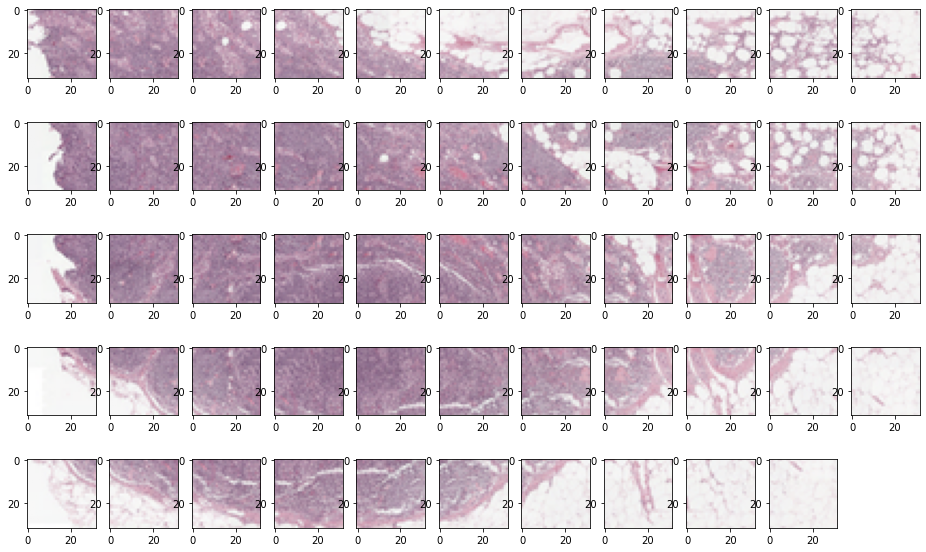

In [88]:
# Find by yourself which of the patches is the one in top right corner of the original image and enter it's index+1 as numer of colums below:
top_right_idx = 10
nb_cols = top_right_idx + 1
nb_rows = int(np.ceil(len(patches) / nb_cols))
plt.figure(figsize=(16,10))
for enu, patch in enumerate(patches):
    plt.subplot(nb_rows, nb_cols, enu+1)
    plt.imshow(patch)

In [133]:
im = Image.open('segmented_img.png')
im.save("segmented_slide.tiff", 'TIFF')

## Patch extraction testing - method 3

In [21]:
def extract_grayscale_patches( img, shape, offset=(0,0), stride=(1,1) ):
    """Extracts (typically) overlapping regular patches from a grayscale image

    Changing the offset and stride parameters will result in images
    reconstructed by reconstruct_from_grayscale_patches having different
    dimensions! Callers should pad and unpad as necessary!

    Args:
        img (HxW ndarray): input image from which to extract patches

        shape (2-element arraylike): shape of that patches as (h,w)

        offset (2-element arraylike): offset of the initial point as (y,x)

        stride (2-element arraylike): vertical and horizontal strides

    Returns:
        patches (ndarray): output image patches as (N,shape[0],shape[1]) array

        origin (2-tuple): array of top and array of left coordinates
    """
    px, py = np.meshgrid( np.arange(shape[1]),np.arange(shape[0]))
    l, t = np.meshgrid(np.arange(offset[1], img.shape[1]-shape[1]+1, stride[1]),
                       np.arange(offset[0], img.shape[0]-shape[0]+1, stride[0])
                      )
    l = l.ravel()
    t = t.ravel()
    x = np.tile( px[None,:,:], (t.size,1,1)) + np.tile( l[:,None,None], (1,shape[0],shape[1]))
    y = np.tile( py[None,:,:], (t.size,1,1)) + np.tile( t[:,None,None], (1,shape[0],shape[1]))
    for i in range(img.shape[3]):
        img[:, :, i] = img[y.ravel(), x.ravel(), i].reshape((t.size, shape[0], shape[1]))
        
    return img[y.ravel(), x.ravel()].reshape((t.size, shape[0], shape[1])), (t,l)


def reconstruct_from_grayscale_patches( patches, origin, epsilon=1e-12 ):
    """Rebuild an image from a set of patches by averaging

    The reconstructed image will have different dimensions than the
    original image if the strides and offsets of the patches were changed
    from the defaults!

    Args:
        patches (ndarray): input patches as (N,patch_height,patch_width) array

        origin (2-tuple): top and left coordinates of each patch

        epsilon (scalar): regularization term for averaging when patches
            some image pixels are not covered by any patch

    Returns:
        image (ndarray): output image reconstructed from patches of
            size ( max(origin[0])+patches.shape[1], max(origin[1])+patches.shape[2])

        weight (ndarray): output weight matrix consisting of the count
            of patches covering each pixel
    """
    patch_width  = patches.shape[2]
    patch_height = patches.shape[1]
    img_width    = np.max( origin[1] ) + patch_width
    img_height   = np.max( origin[0] ) + patch_height

    out = np.zeros( (img_height,img_width) )
    wgt = np.zeros( (img_height,img_width) )
    for i in range(patch_height):
        for j in range(patch_width):
            out[origin[0]+i, origin[1]+j] += patches[:,i,j]
            wgt[origin[0]+i, origin[1]+j] += 1.0

    return out/np.maximum( wgt, epsilon ), wgt

In [22]:
import time

In [ ]:
img_orig = cv2.imread('segmented_img.png')[:,:,::-1]
# img_orig1 = cv2.imread('segmented_img.png')[:,:,:]
img = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)

# print('img_orig1.shape: ', img_orig1.shape)
print('img_orig.shape: ', img_orig.shape)
# print('img.shape: ', img.shape)

# plt.figure(figsize = (30,20))
# plt.imshow( cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB) )

print(img[:,:].shape)
start = time.time()
p, origin = extract_grayscale_patches( img, (256, 256), stride=(64, 64) )
print("p.shape: ", p.shape)
print("origin[0].shape, origin[1].shape: ", origin[0].shape, origin[1].shape)
end = time.time()
print( 'Patch extraction took: {}s'.format(np.round(end-start,2)) )
start = time.time()
r, w = reconstruct_from_grayscale_patches( p, origin )
end = time.time()
print('Image reconstruction took: {}s'.format(np.round(end-start,2)) )
print( 'Reconstruction error is: {}'.format( np.linalg.norm( img[:r.shape[0],:r.shape[1]]-r ) ) )

plt.figure(figsize = (30,20))
plt.subplot( 131 )
plt.imshow( img[:,:] )
plt.title('Input image')
plt.subplot( 132 )
plt.imshow( r )
plt.title('Reconstructed image')
# plt.savefig('receonstructed.png')
plt.show()